In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

In [9]:
# Load the datasets
file_path = "spreadspoke_scores.csv"  # Update this with the correct path if needed
teams_file_path = "nfl_teams.csv"
nfl_data = pd.read_csv(file_path)
nfl_teams = pd.read_csv(teams_file_path)

# Convert 'schedule_date' to datetime format
nfl_data["schedule_date"] = pd.to_datetime(nfl_data["schedule_date"], errors="coerce")

start_date = pd.Timestamp("1998-09-06")
nfl_data_filtered = nfl_data[nfl_data["schedule_date"] >= start_date].copy()

# Convert numerical columns (some may be stored as strings)
nfl_data_filtered["spread_favorite"] = pd.to_numeric(nfl_data_filtered["spread_favorite"], errors="coerce")
nfl_data_filtered["over_under_line"] = pd.to_numeric(nfl_data_filtered["over_under_line"], errors="coerce")

# Standardize team names by merging with nfl_teams data
team_mapping = nfl_teams.set_index("team_name")["team_id"].to_dict()
nfl_data_filtered["team_home_id"] = nfl_data_filtered["team_home"].map(team_mapping)
nfl_data_filtered["team_away_id"] = nfl_data_filtered["team_away"].map(team_mapping)

# Correct NJY to NYJ
nfl_data_filtered["team_favorite_id"] = nfl_data_filtered["team_favorite_id"].replace("NJY", "NYJ")

# Handle PICK case
nfl_data_filtered.loc[nfl_data_filtered["team_favorite_id"] == "PICK", "spread_favorite"] = 0

# Compute actual point spread
nfl_data_filtered["actual_spread"] = np.where(
    nfl_data_filtered["team_home_id"] == nfl_data_filtered["team_favorite_id"],
    nfl_data_filtered["score_away"] - nfl_data_filtered["score_home"],  # Favorite is home
    nfl_data_filtered["score_home"] - nfl_data_filtered["score_away"]   # Favorite is away
)

nfl_data_filtered["actual_total_points"] = nfl_data_filtered["score_home"] + nfl_data_filtered["score_away"]

# Compute error between actual values and sportsbook lines
nfl_data_filtered["spread_error"] = nfl_data_filtered["actual_spread"] - nfl_data_filtered["spread_favorite"]
nfl_data_filtered["total_points_error"] = nfl_data_filtered["actual_total_points"] - nfl_data_filtered["over_under_line"]

# Classify spread correctness (1 if underdog won, 0 otherwise)
nfl_data_filtered["underdog_won"] = (nfl_data_filtered["actual_spread"] > 0).astype(int)

# Classify over/under correctness (1 if actual points > line, 0 otherwise)
nfl_data_filtered["over_hit"] = (nfl_data_filtered["actual_total_points"] > nfl_data_filtered["over_under_line"]).astype(int)

# Assume missing weather data means the game was played outdoors
nfl_data_filtered["weather_detail"].fillna("outdoor", inplace=True)

# Remove duplicates if any
nfl_data_cleaned = nfl_data_filtered.drop_duplicates()

nfl_data_cleaned.to_csv('nfl_data_cleaned.csv', index=False)



/var/folders/hj/_jmscth928bcdm9fr013zqzr0000gn/T/ipykernel_14148/797737228.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  nfl_data_filtered["weather_detail"].fillna("outdoor", inplace=True)


In [199]:
nfl_data_cleaned

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,team_home_id,team_away_id,actual_spread,actual_total_points,spread_error,total_points_error,rolling_spread_error,rolling_total_points_error,underdog_won,over_hit
4039,1986-01-26,1985,Superbowl,True,Chicago Bears,46,10,New England Patriots,CHI,-10.0,...,CHI,NE,-36,56,-26.0,18.5,-26.00,18.50,0,1
4040,1986-09-07,1986,1,False,Buffalo Bills,24,28,New York Jets,NYJ,-6.0,...,BUF,NYJ,-4,52,2.0,12.0,2.00,12.00,0,1
4041,1986-09-07,1986,1,False,Chicago Bears,41,31,Cleveland Browns,CHI,-10.5,...,CHI,CLE,-10,72,0.5,34.0,-12.75,26.25,0,1
4042,1986-09-07,1986,1,False,Denver Broncos,38,36,Los Angeles Raiders,DEN,-3.0,...,DEN,LVR,-2,74,1.0,35.5,1.00,35.50,0,1
4043,1986-09-07,1986,1,False,Green Bay Packers,3,31,Houston Oilers,GB,-4.0,...,GB,TEN,28,34,32.0,-7.5,32.00,-7.50,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14081,2025-01-19,2024,Division,True,Buffalo Bills,27,25,Baltimore Ravens,BAL,-1.5,...,BUF,BAL,2,52,3.5,0.0,-7.80,-1.30,1,0
14082,2025-01-19,2024,Division,True,Philadelphia Eagles,28,22,Los Angeles Rams,PHI,-7.0,...,PHI,LAR,-6,50,1.0,6.5,-5.80,4.40,0,1
14083,2025-01-26,2024,Conference,True,Philadelphia Eagles,55,23,Washington Commanders,PHI,-6.0,...,PHI,WAS,-32,78,-26.0,31.0,-12.40,6.20,0,1
14084,2025-01-26,2024,Conference,True,Kansas City Chiefs,32,29,Buffalo Bills,KC,-1.0,...,KC,BUF,-3,61,-2.0,11.5,-6.60,-1.90,0,1


In [202]:
# Create backtesting windows
n_splits = 10  # Define the number of backtesting splits, 10 means each split cover 4-5 years
tscv = TimeSeriesSplit(n_splits=n_splits)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next v

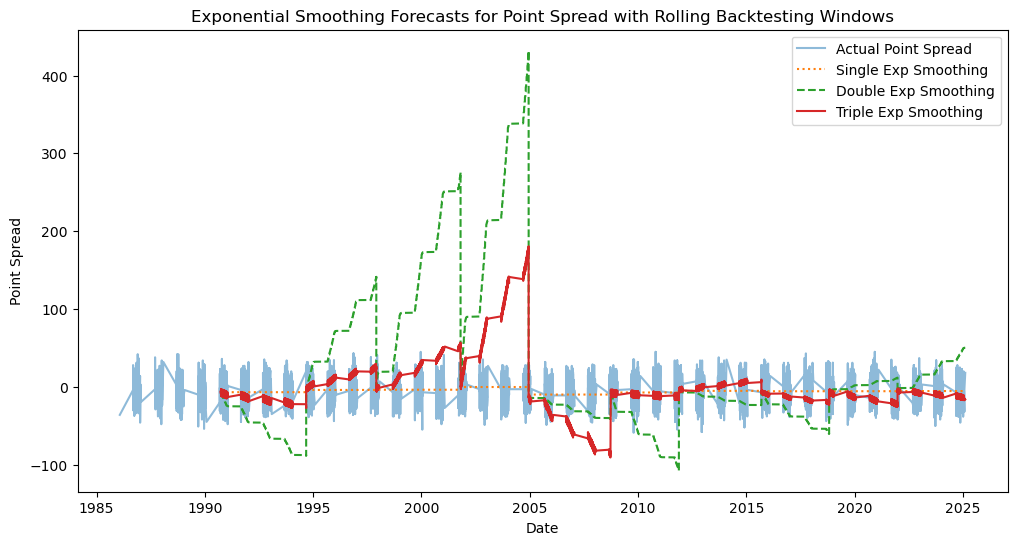

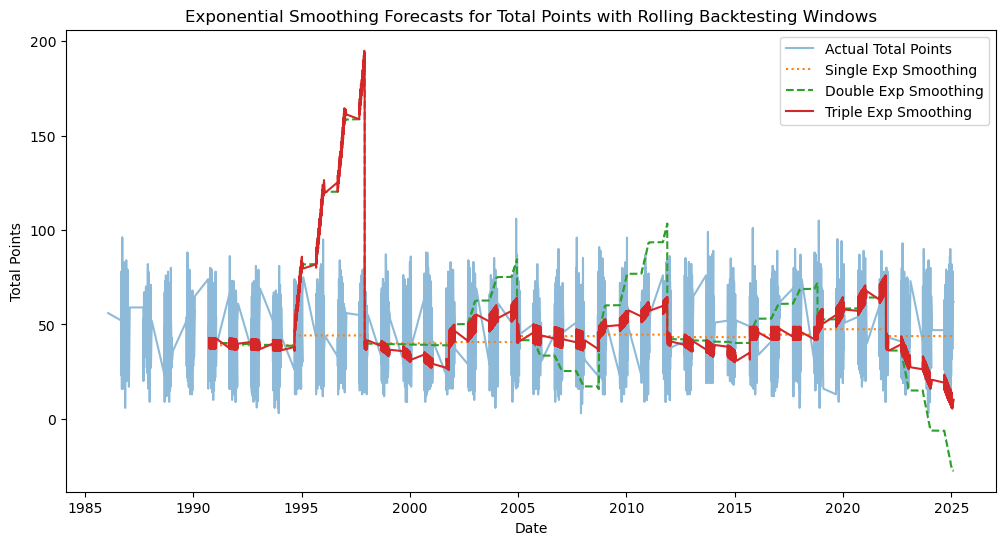

Average RMSE for actual_spread: {'single': 193.39499255541605, 'double': 11073.88880646953, 'triple': 1797.4141751220297}
Average MAE for actual_spread: {'single': 10.820492822811591, 'double': 64.94264237212435, 'triple': 26.698133729818608}
Average MAPE for actual_spread: {'single': inf, 'double': inf, 'triple': inf}
Average RMSE for actual_total_points: {'single': 197.6669395232007, 'double': 1373.342503634089, 'triple': 1091.030868273489}
Average MAE for actual_total_points: {'single': 11.14994819763663, 'double': 25.542994366042013, 'triple': 20.494304616921944}
Average MAPE for actual_total_points: {'single': 32.1664194918095, 'double': 71.28378430905045, 'triple': 57.5360637470666}


/var/folders/hj/_jmscth928bcdm9fr013zqzr0000gn/T/ipykernel_4888/654522432.py:42: RuntimeWarning: divide by zero encountered in divide
  metrics = {"rmse": mean_squared_error, "mae": mean_absolute_error, "mape": lambda y, y_pred: np.mean(np.abs((y - y_pred) / y)) * 100}


In [203]:
# Adjust seasonal period based on NFL season length
seasonal_period = 16  # Approximate number of games in an NFL season

# Apply ETS over rolling forecast approach for both point spread and total points
for target in ["actual_spread", "actual_total_points"]:
    nfl_data_cleaned[f"{target}_single_exp"] = None
    nfl_data_cleaned[f"{target}_double_exp"] = None
    nfl_data_cleaned[f"{target}_triple_exp"] = None
    
    for train_index, test_index in tscv.split(nfl_data_cleaned):
        train, test = nfl_data_cleaned.iloc[train_index], nfl_data_cleaned.iloc[test_index]
        
        # Apply Single, Double, and Triple Exponential Smoothing
        model_single = SimpleExpSmoothing(train[target]).fit()
        model_double = ExponentialSmoothing(train[target], trend='add').fit()
        model_triple = ExponentialSmoothing(train[target], trend='add', seasonal='add', seasonal_periods=seasonal_period).fit()
        
        nfl_data_cleaned.loc[test.index, f"{target}_single_exp"] = model_single.forecast(len(test)).values
        nfl_data_cleaned.loc[test.index, f"{target}_double_exp"] = model_double.forecast(len(test)).values
        nfl_data_cleaned.loc[test.index, f"{target}_triple_exp"] = model_triple.forecast(len(test)).values

# Convert forecast columns to numeric type
for target in ["actual_spread", "actual_total_points"]:
    for method in ["single_exp", "double_exp", "triple_exp"]:
        nfl_data_cleaned[f"{target}_{method}"] = pd.to_numeric(nfl_data_cleaned[f"{target}_{method}"], errors="coerce")

# Plot ETS results as continuous forecast lines for both point spread and total points
for target, label in zip(["actual_spread", "actual_total_points"], ["Point Spread", "Total Points"]):
    plt.figure(figsize=(12, 6))
    plt.plot(nfl_data_cleaned["schedule_date"], nfl_data_cleaned[target], label=f"Actual {label}", alpha=0.5)
    plt.plot(nfl_data_cleaned["schedule_date"], nfl_data_cleaned[f"{target}_single_exp"], label="Single Exp Smoothing", linestyle='dotted')
    plt.plot(nfl_data_cleaned["schedule_date"], nfl_data_cleaned[f"{target}_double_exp"], label="Double Exp Smoothing", linestyle='dashed')
    plt.plot(nfl_data_cleaned["schedule_date"], nfl_data_cleaned[f"{target}_triple_exp"], label="Triple Exp Smoothing", linestyle='solid')
    
    plt.xlabel("Date")
    plt.ylabel(label)
    plt.title(f"Exponential Smoothing Forecasts for {label} with Rolling Backtesting Windows")
    plt.legend()
    plt.show()

# Compute RMSE, MAE, and MAPE for both point spread and total points
metrics = {"rmse": mean_squared_error, "mae": mean_absolute_error, "mape": lambda y, y_pred: np.mean(np.abs((y - y_pred) / y)) * 100}
for target in ["actual_spread", "actual_total_points"]:
    for metric_name, metric_func in metrics.items():
        scores = {"single": [], "double": [], "triple": []}
        
        for train_index, test_index in tscv.split(nfl_data_cleaned):
            test = nfl_data_cleaned.iloc[test_index]
            for method in ["single_exp", "double_exp", "triple_exp"]:
                scores[method.split('_')[0]].append(metric_func(test[target].values, test[f"{target}_{method}"].values))
        
        print(f"Average {metric_name.upper()} for {target}:", {key: np.mean(values) for key, values in scores.items()})


Single Exponential Smoothing (SES) appears to be the best choice for over/under predictions because the over/under and points spread lines don't exhibit a strong trend or seasonality. Unlike team performance metrics (which may trend over time), over/under lines and spread are set independently for each game based on team matchups, injuries, and other short-term factors.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next v

Average RMSE for spread_error: {'single': 177.9231068028135, 'double': 9182.623904089616, 'triple': 1313.922605232665}
Average MAE for spread_error: {'single': 10.401453599365817, 'double': 54.84257142335264, 'triple': 22.15431376429938}
Average MAPE for spread_error: {'single': inf, 'double': inf, 'triple': inf}
Average RMSE for total_points_error: {'single': 186.0745490667007, 'double': 1851.564576386032, 'triple': 531.1125065277149}
Average MAE for total_points_error: {'single': 10.814469649579468, 'double': 32.716500158871945, 'triple': 16.27887080671173}
Average MAPE for total_points_error: {'single': inf, 'double': inf, 'triple': inf}
Average RMSE for underdog_won: {'single': 0.22320021569084925, 'double': 0.2227792588198198, 'triple': 0.22347881330438332}
Average MAE for underdog_won: {'single': 0.4448760390062138, 'double': 0.44677839550067117, 'triple': 0.44627702085645754}
Average MAPE for underdog_won: {'single': inf, 'double': inf, 'triple': inf}
Average RMSE for over_hit: 

/var/folders/hj/_jmscth928bcdm9fr013zqzr0000gn/T/ipykernel_4888/2058090649.py:25: RuntimeWarning: divide by zero encountered in divide
  metrics = {"rmse": mean_squared_error, "mae": mean_absolute_error, "mape": lambda y, y_pred: np.mean(np.abs((y - y_pred) / y)) * 100}
/var/folders/hj/_jmscth928bcdm9fr013zqzr0000gn/T/ipykernel_4888/2058090649.py:25: RuntimeWarning: divide by zero encountered in divide
  metrics = {"rmse": mean_squared_error, "mae": mean_absolute_error, "mape": lambda y, y_pred: np.mean(np.abs((y - y_pred) / y)) * 100}


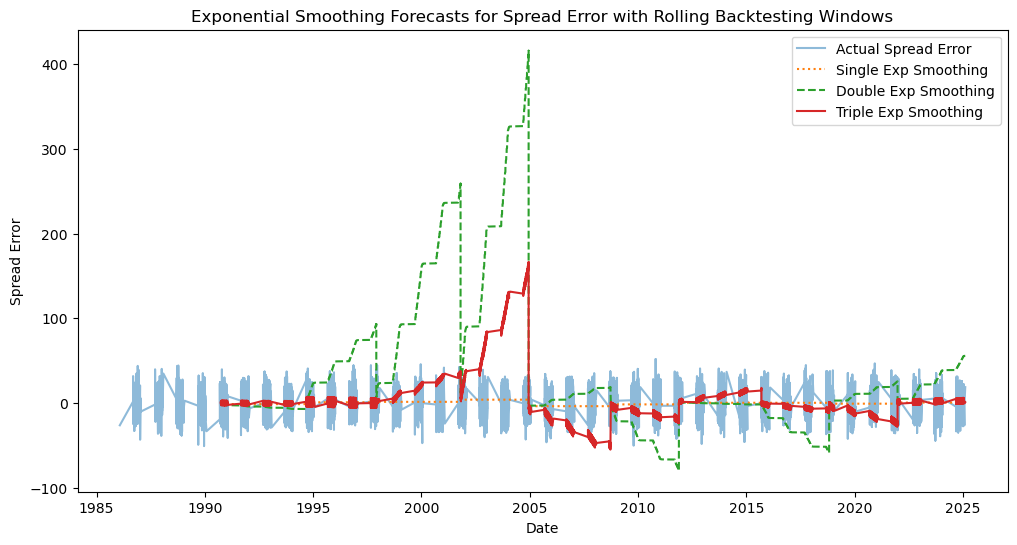

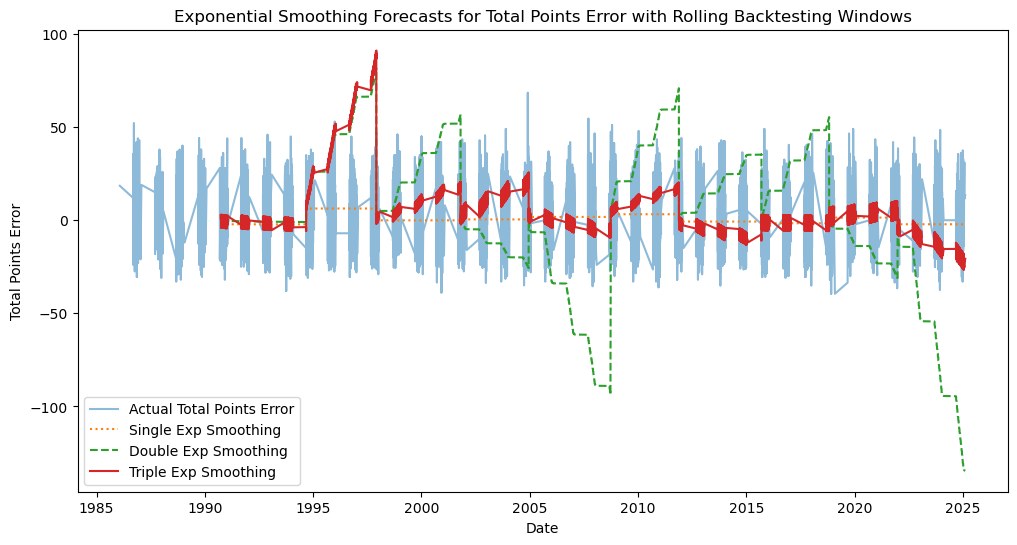

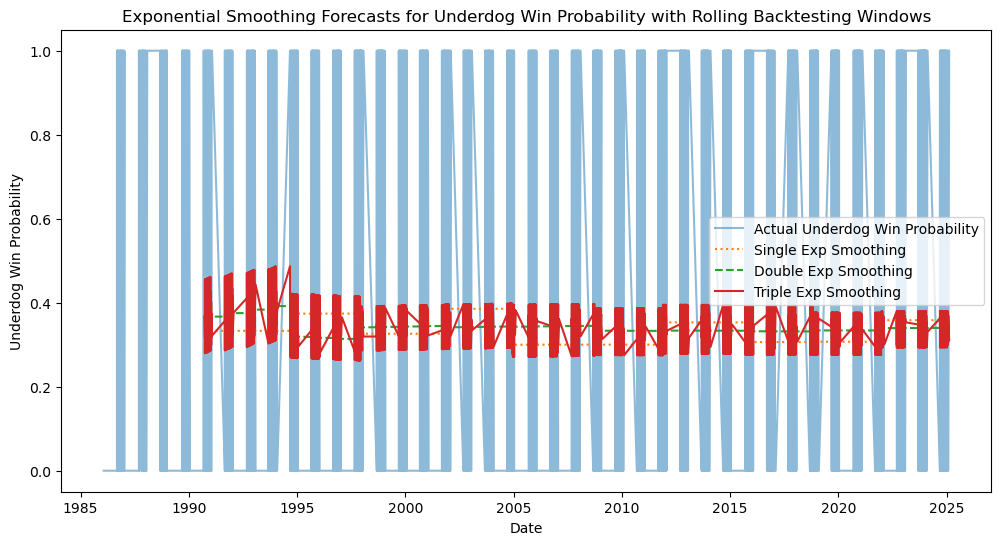

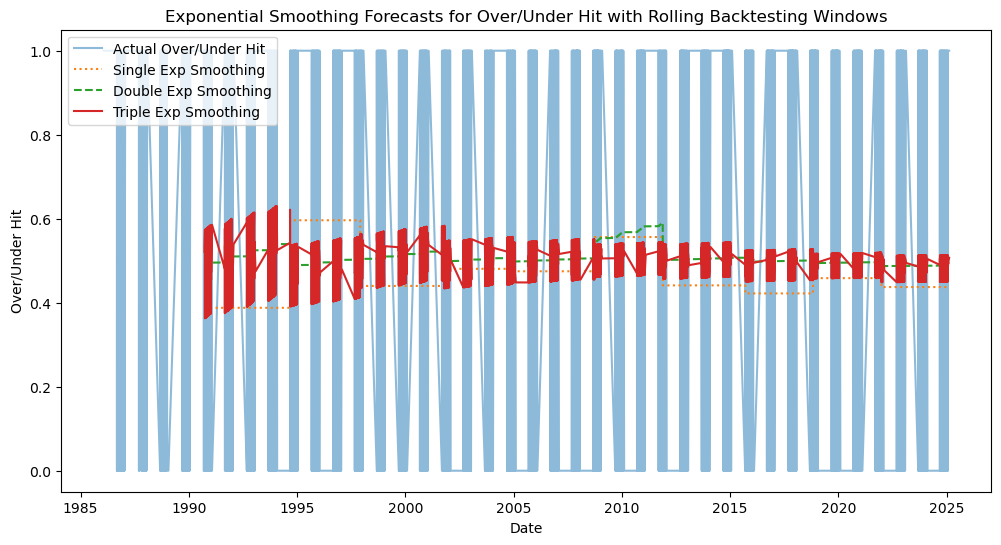

In [204]:
# Apply ETS over rolling forecast approach for spread error, total points error, and classification targets
for target in ["spread_error", "total_points_error", "underdog_won", "over_hit"]:
    nfl_data_cleaned[f"{target}_single_exp"] = None
    nfl_data_cleaned[f"{target}_double_exp"] = None
    nfl_data_cleaned[f"{target}_triple_exp"] = None
    
    for train_index, test_index in tscv.split(nfl_data_cleaned):
        train, test = nfl_data_cleaned.iloc[train_index], nfl_data_cleaned.iloc[test_index]
        
        # Apply Single, Double, and Triple Exponential Smoothing
        model_single = SimpleExpSmoothing(train[target]).fit()
        model_double = ExponentialSmoothing(train[target], trend='add').fit()
        model_triple = ExponentialSmoothing(train[target], trend='add', seasonal='add', seasonal_periods=seasonal_period).fit()
        
        nfl_data_cleaned.loc[test.index, f"{target}_single_exp"] = model_single.forecast(len(test)).values
        nfl_data_cleaned.loc[test.index, f"{target}_double_exp"] = model_double.forecast(len(test)).values
        nfl_data_cleaned.loc[test.index, f"{target}_triple_exp"] = model_triple.forecast(len(test)).values

# Convert forecast columns to numeric type
for target in ["spread_error", "total_points_error", "underdog_won", "over_hit"]:
    for method in ["single_exp", "double_exp", "triple_exp"]:
        nfl_data_cleaned[f"{target}_{method}"] = pd.to_numeric(nfl_data_cleaned[f"{target}_{method}"], errors="coerce")

# Compute RMSE, MAE, and MAPE for error predictions
metrics = {"rmse": mean_squared_error, "mae": mean_absolute_error, "mape": lambda y, y_pred: np.mean(np.abs((y - y_pred) / y)) * 100}
for target in ["spread_error", "total_points_error", "underdog_won", "over_hit"]:
    for metric_name, metric_func in metrics.items():
        scores = {"single": [], "double": [], "triple": []}
        
        for train_index, test_index in tscv.split(nfl_data_cleaned):
            test = nfl_data_cleaned.iloc[test_index]
            for method in ["single_exp", "double_exp", "triple_exp"]:
                scores[method.split('_')[0]].append(metric_func(test[target].values, test[f"{target}_{method}"].values))
        
        print(f"Average {metric_name.upper()} for {target}:", {key: np.mean(values) for key, values in scores.items()})

# Plot ETS forecast results
import matplotlib.pyplot as plt
for target, label in zip(["spread_error", "total_points_error", "underdog_won", "over_hit"],
                         ["Spread Error", "Total Points Error", "Underdog Win Probability", "Over/Under Hit"]):
    plt.figure(figsize=(12, 6))
    plt.plot(nfl_data_cleaned["schedule_date"], nfl_data_cleaned[target], label=f"Actual {label}", alpha=0.5)
    plt.plot(nfl_data_cleaned["schedule_date"], nfl_data_cleaned[f"{target}_single_exp"], label="Single Exp Smoothing", linestyle='dotted')
    plt.plot(nfl_data_cleaned["schedule_date"], nfl_data_cleaned[f"{target}_double_exp"], label="Double Exp Smoothing", linestyle='dashed')
    plt.plot(nfl_data_cleaned["schedule_date"], nfl_data_cleaned[f"{target}_triple_exp"], label="Triple Exp Smoothing", linestyle='solid')
    
    plt.xlabel("Date")
    plt.ylabel(label)
    plt.title(f"Exponential Smoothing Forecasts for {label} with Rolling Backtesting Windows")
    plt.legend()
    plt.show()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next v

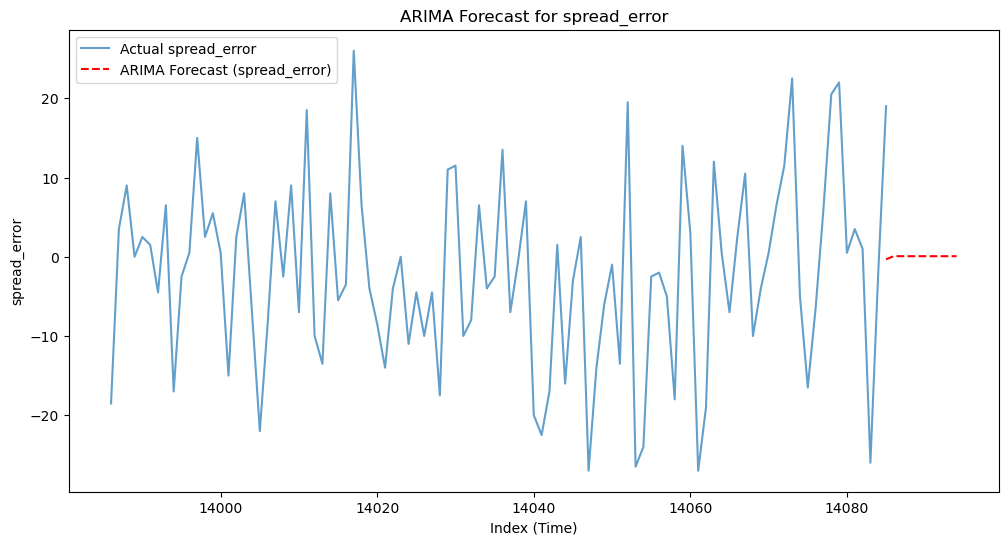

ARIMA Model Summary for spread_error:
                               SARIMAX Results                                
Dep. Variable:           spread_error   No. Observations:                10047
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -40232.473
Date:                Mon, 17 Feb 2025   AIC                          80470.946
Time:                        18:25:25   BIC                          80492.591
Sample:                             0   HQIC                         80478.271
                              - 10047                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0206      0.010     -2.035      0.042      -0.040      -0.001
ma.L1         -0.9999      0.002   -630.362      0.000      -1.003      -0.997
sigma2       1

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next v

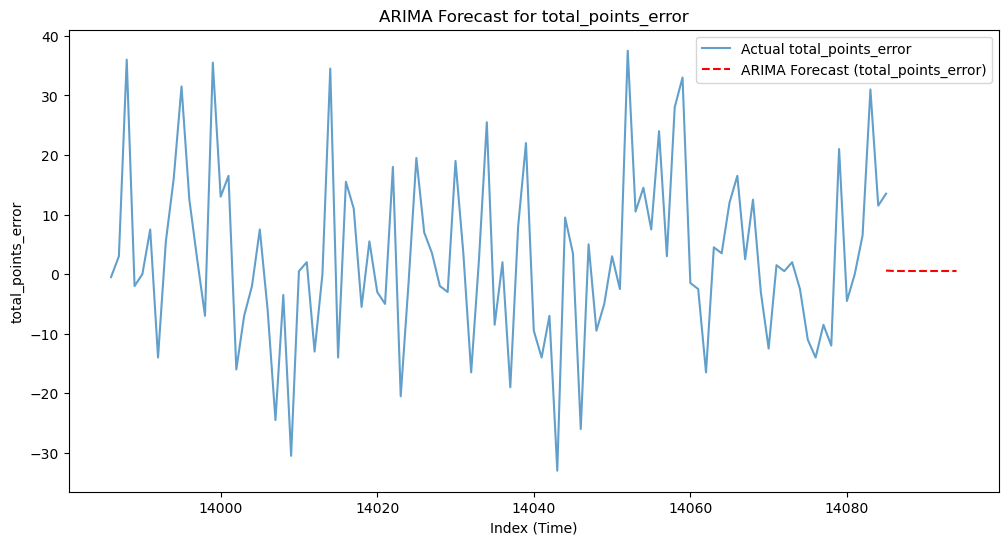

ARIMA Model Summary for total_points_error:
                               SARIMAX Results                                
Dep. Variable:     total_points_error   No. Observations:                10047
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -40406.838
Date:                Mon, 17 Feb 2025   AIC                          80819.676
Time:                        18:25:26   BIC                          80841.321
Sample:                             0   HQIC                         80827.001
                              - 10047                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0054      0.010      0.545      0.586      -0.014       0.025
ma.L1         -0.9995      0.000  -2576.318      0.000      -1.000      -0.999
sigma2  

In [205]:
from statsmodels.tsa.arima.model import ARIMA

# Define function to apply ARIMA and forecast spread error and total points error
def apply_arima(target, order=(1,1,1), forecast_steps=10):
    """
    Fits an ARIMA model to the given target variable and plots forecast results.
    
    Parameters:
    - target: str, name of the target variable (e.g., "spread_error", "total_points_error").
    - order: tuple, ARIMA(p,d,q) order.
    - forecast_steps: int, number of future steps to forecast.
    """
    # Drop NA values (ARIMA can't handle missing data)
    df = nfl_data_cleaned.dropna(subset=[target]).copy()
    
    # Fit ARIMA model
    model = ARIMA(df[target], order=order)
    fitted_model = model.fit()
    
    # Forecast future values
    forecast = fitted_model.forecast(steps=forecast_steps)
    
    # Plot actual vs forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-100:], df[target].iloc[-100:], label=f"Actual {target}", alpha=0.7)
    plt.plot(range(df.index[-1], df.index[-1] + forecast_steps), forecast, label=f"ARIMA Forecast ({target})", linestyle='dashed', color='red')
    plt.xlabel("Index (Time)")
    plt.ylabel(target)
    plt.title(f"ARIMA Forecast for {target}")
    plt.legend()
    plt.show()
    
    # Print model summary
    print(f"ARIMA Model Summary for {target}:")
    print(fitted_model.summary())

# Apply ARIMA to spread error and total points error
apply_arima("spread_error")
apply_arima("total_points_error")


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:25:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:25:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Underdog Win Prediction Metrics:
{'Accuracy': 0.654228855721393, 'Precision': 0.5239179954441914, 'Recall': 0.32122905027932963, 'F1 Score': 0.39826839826839827}

Over/Under Hit Prediction Metrics:
{'Accuracy': 0.6104477611940299, 'Precision': 0.5942982456140351, 'Recall': 0.5675392670157068, 'F1 Score': 0.5806106052490627}


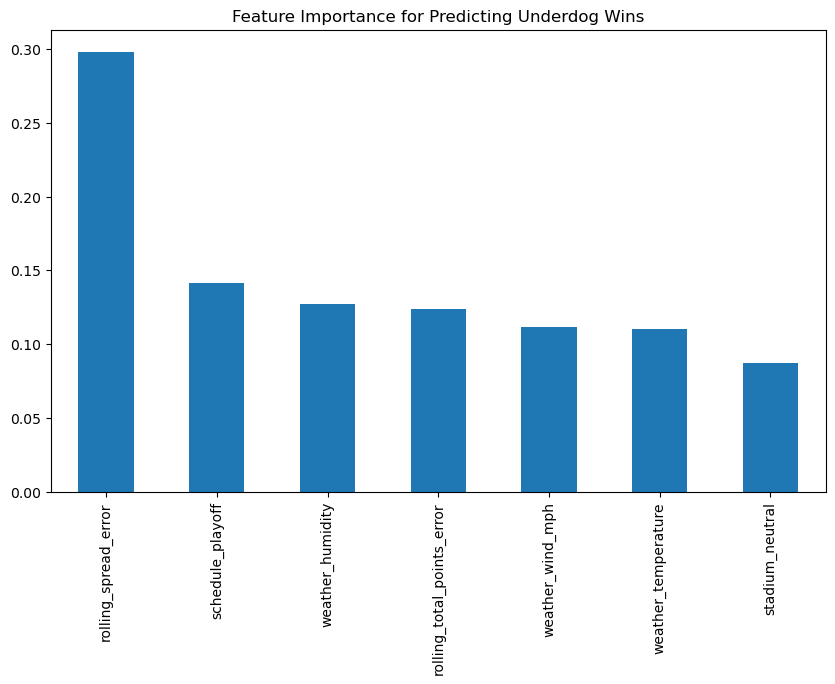

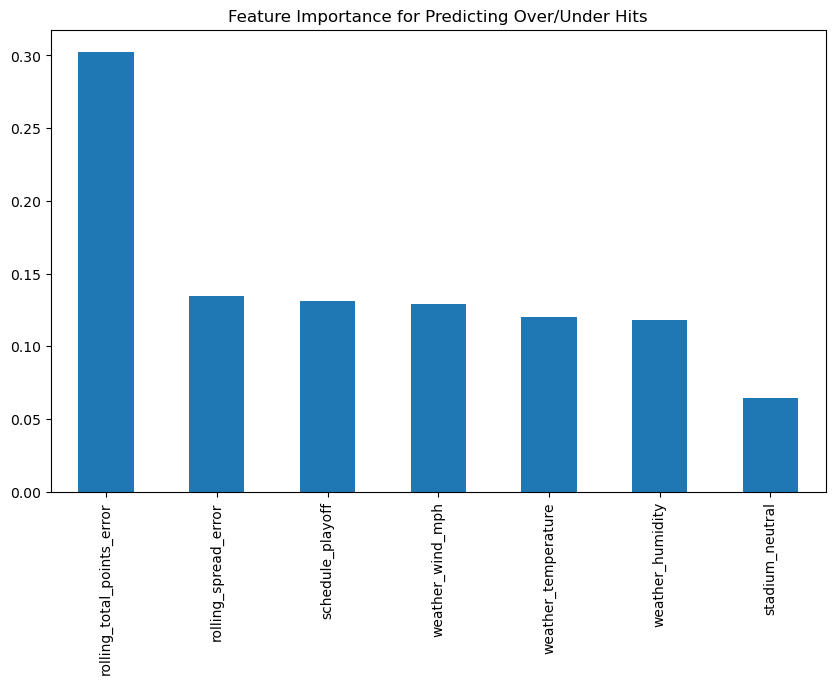

In [206]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Select features for classification
features = ["rolling_spread_error", "rolling_total_points_error", "stadium_neutral", "weather_temperature", "weather_wind_mph", "weather_humidity","schedule_playoff"]
X = nfl_data_cleaned[features]

# Predicting underdog wins
y_underdog = nfl_data_cleaned["underdog_won"]

# Predicting over/under hit
y_over = nfl_data_cleaned["over_hit"]

# Train-test split (80-20)
X_train, X_test, y_underdog_train, y_underdog_test = train_test_split(X, y_underdog, test_size=0.2, random_state=42)
X_train, X_test, y_over_train, y_over_test = train_test_split(X, y_over, test_size=0.2, random_state=42)

# Train XGBoost models for feature importance
xgb_underdog = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_underdog.fit(X_train, y_underdog_train)

xgb_over = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_over.fit(X_train, y_over_train)

# Get feature importance
feature_importance_underdog = pd.Series(xgb_underdog.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importance_over = pd.Series(xgb_over.feature_importances_, index=X.columns).sort_values(ascending=False)

# Calculate evaluation metrics
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred)
    }

results_underdog = evaluate_model(xgb_underdog, X_test, y_underdog_test)
results_over = evaluate_model(xgb_over, X_test, y_over_test)

# Print results
print("Underdog Win Prediction Metrics:")
print(results_underdog)
print("\nOver/Under Hit Prediction Metrics:")
print(results_over)

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance_underdog.plot(kind='bar', title='Feature Importance for Predicting Underdog Wins')
plt.show()

plt.figure(figsize=(10, 6))
feature_importance_over.plot(kind='bar', title='Feature Importance for Predicting Over/Under Hits')
plt.show()


In [207]:
# Identify teams with the largest spread errors (absolute values indicate magnitude of mispricing)
team_spread_errors = nfl_data_cleaned.groupby("team_favorite_id")["spread_error"].mean().abs().sort_values(ascending=False)

# Identify teams with the largest total points errors (mispriced over/under lines)
team_total_errors = nfl_data_cleaned.groupby("team_favorite_id")["total_points_error"].mean().abs().sort_values(ascending=False)

# Identify weather conditions where the spread was most mispriced
weather_spread_errors = nfl_data_cleaned.groupby("weather_detail")["spread_error"].mean().abs().sort_values(ascending=False)

# Identify weather conditions where the total points were most mispriced
weather_total_errors = nfl_data_cleaned.groupby("weather_detail")["total_points_error"].mean().abs().sort_values(ascending=False)

# Display results
print("Team Spread Errors:")
print(team_spread_errors)

print("\nTeam Total Points Errors:")
print(team_total_errors)

print("\nWeather Spread Errors:")
print(weather_spread_errors)

print("\nWeather Total Points Errors:")
print(weather_total_errors)

Team Spread Errors:
team_favorite_id
LV      2.500000
BAL     2.264214
LVR     2.244485
NYJ     2.124000
CLE     1.742991
SF      1.606729
TEN     1.430421
WAS     1.360424
MIA     1.349840
BUF     1.337176
ARI     1.307317
HOU     1.281879
CIN     1.267790
NE      1.205463
GB      1.074755
KC      0.859536
CAR     0.720379
TB      0.694757
PHI     0.604061
NO      0.543296
LAR     0.454098
NYG     0.388350
JAX     0.358639
PICK    0.351064
MIN     0.307388
PIT     0.300983
DEN     0.299505
ATL     0.290941
DAL     0.257895
SEA     0.229851
LAC     0.094937
DET     0.065126
IND     0.049699
CHI     0.049470
Name: spread_error, dtype: float64

Team Total Points Errors:
team_favorite_id
DET     2.523109
LV      2.000000
CIN     1.889513
CHI     1.704947
LVR     1.485294
DEN     1.438119
NO      1.329609
GB      1.246324
BUF     1.237752
TB      1.054682
PICK    0.994681
LAC     0.950949
DAL     0.893421
IND     0.796687
PHI     0.782995
WAS     0.743816
TEN     0.741100
PIT     0.567568


In [209]:
# Identify playoff games where the spread was most mispriced
playoff_spread_errors = nfl_data_cleaned.groupby("schedule_playoff")["spread_error"].mean().abs().sort_values(ascending=False)

# Identify playoff games where the total points were most mispriced
playoff_total_errors = nfl_data_cleaned.groupby("schedule_playoff")["total_points_error"].mean().abs().sort_values(ascending=False)

# Identify stadiums where the spread was most mispriced
stadium_spread_errors = nfl_data_cleaned.groupby("stadium")["spread_error"].mean().abs().sort_values(ascending=False)

# Identify stadiums where the total points were most mispriced
stadium_total_errors = nfl_data_cleaned.groupby("stadium")["total_points_error"].mean().abs().sort_values(ascending=False)

# Display results
print("Playoff Spread Errors:\n", playoff_spread_errors.to_string())
print("\nPlayoff Total Points Errors:\n", playoff_total_errors.to_string())
print("\nStadium Spread Errors:\n", stadium_spread_errors.to_string())
print("\nStadium Total Points Errors:\n", stadium_total_errors.to_string())

Playoff Spread Errors:
 schedule_playoff
False    0.072179
True     0.054398

Playoff Total Points Errors:
 schedule_playoff
True     1.423611
False    0.589995

Stadium Spread Errors:
 stadium
Jack Murphy Stadium                    35.000000
Tottenham Stadium                      21.000000
Rose Bowl                              19.000000
Twickenham Stadium                     14.000000
Estadio Azteca                         10.400000
Tampa Stadium                           8.000000
Orange Bowl                             7.500000
Pro Player Stadium                      7.500000
TCF Bank Stadium                        6.750000
Alamo Dome                              6.000000
Dignity Health Sports Park              5.714286
Memorial Stadium (Clemson)              5.312500
Dolphin Stadium                         5.000000
Rogers Centre                           4.500000
Frankfurt Stadium                       4.250000
Tottenham Hotspur Stadium               4.050000
Alltel Stadium        

In [230]:
from xgboost import XGBRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import norm

# Include schedule_playoff as a feature
features = [
    "spread_favorite", 
    "over_under_line", 
    "weather_temperature", 
    "weather_wind_mph", 
    "weather_humidity", 
    "stadium_neutral",
    "schedule_playoff"
]

X = nfl_data_cleaned[features]
y_spread = nfl_data_cleaned["actual_spread"]
y_total = nfl_data_cleaned["actual_total_points"]

# Train-test split (ensure consistency; you may want to use the same split for both targets)
X_train, X_test, y_spread_train, y_spread_test = train_test_split(X, y_spread, test_size=0.2, random_state=42)
X_train, X_test, y_total_train, y_total_test = train_test_split(X, y_total, test_size=0.2, random_state=42)

spread_model = XGBRegressor()
spread_model.fit(X_train, y_spread_train)

total_model = XGBRegressor()
total_model.fit(X_train, y_total_train)

def predict_lines(spread_favorite, over_under_line, weather_temperature, weather_wind_mph, weather_humidity, stadium_neutral, schedule_playoff, sigma_total=5.0, sigma_spread=3.0):
    input_data = pd.DataFrame({
        "spread_favorite": [spread_favorite],
        "over_under_line": [over_under_line],
        "weather_temperature": [weather_temperature],
        "weather_wind_mph": [weather_wind_mph],
        "weather_humidity": [weather_humidity],
        "stadium_neutral": [stadium_neutral],
        "schedule_playoff": [schedule_playoff]
    })
    
    predicted_spread = spread_model.predict(input_data)[0]
    predicted_total = total_model.predict(input_data)[0]
    
    # Over/Under calculations using a normal distribution assumption for total points
    prob_over = 1 - norm.cdf(over_under_line, loc=predicted_total, scale=sigma_total)
    prob_under = norm.cdf(over_under_line, loc=predicted_total, scale=sigma_total)
    over_under_recommendation = "Bet Over" if predicted_total > over_under_line else "Bet Under"
    
    # Spread calculations assuming lower predicted spread (more negative) means a stronger favorite cover
    prob_fav_cover = norm.cdf(spread_favorite, loc=predicted_spread, scale=sigma_spread)
    spread_recommendation = "Bet Favorite Cover" if predicted_spread < spread_favorite else "Bet Underdog Cover"
    prob_underdog_cover = 1 - prob_fav_cover
    
    return {
        "Predicted Spread": predicted_spread,
        "Predicted Total Points": predicted_total,
        "Over/Under Recommendation": over_under_recommendation,
        "Probability Over": prob_over,
        "Probability Under": prob_under,
        "Spread Recommendation": spread_recommendation,
        "Probability Favorite Cover": prob_fav_cover,
        "Probability Underdog Cover": prob_underdog_cover
    }

# Example Usage
example_prediction = predict_lines(
    spread_favorite=-1.5, 
    over_under_line=48.5, 
    weather_temperature=70, 
    weather_wind_mph=0, 
    weather_humidity=33, 
    stadium_neutral=1, 
    schedule_playoff=1  # 1 for playoff game, 0 for regular season
)

for metric, value in example_prediction.items():
    print(f"{metric}: {value}")

Predicted Spread: 9.55747127532959
Predicted Total Points: 54.92669677734375
Over/Under Recommendation: Bet Over
Probability Over: 0.9006631384044227
Probability Under: 0.09933686159557731
Spread Recommendation: Bet Underdog Cover
Probability Favorite Cover: 0.000113982036899393
Probability Underdog Cover: 0.9998860179631006
